In [4]:
pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

--- Starting Network Visualization ---

Generating model architecture diagrams...
✅ Architecture diagram saved to 'generator_architecture.png'
✅ Architecture diagram saved to 'discriminator_architecture.png'

Visualizing generator's first layer convolutional filters...


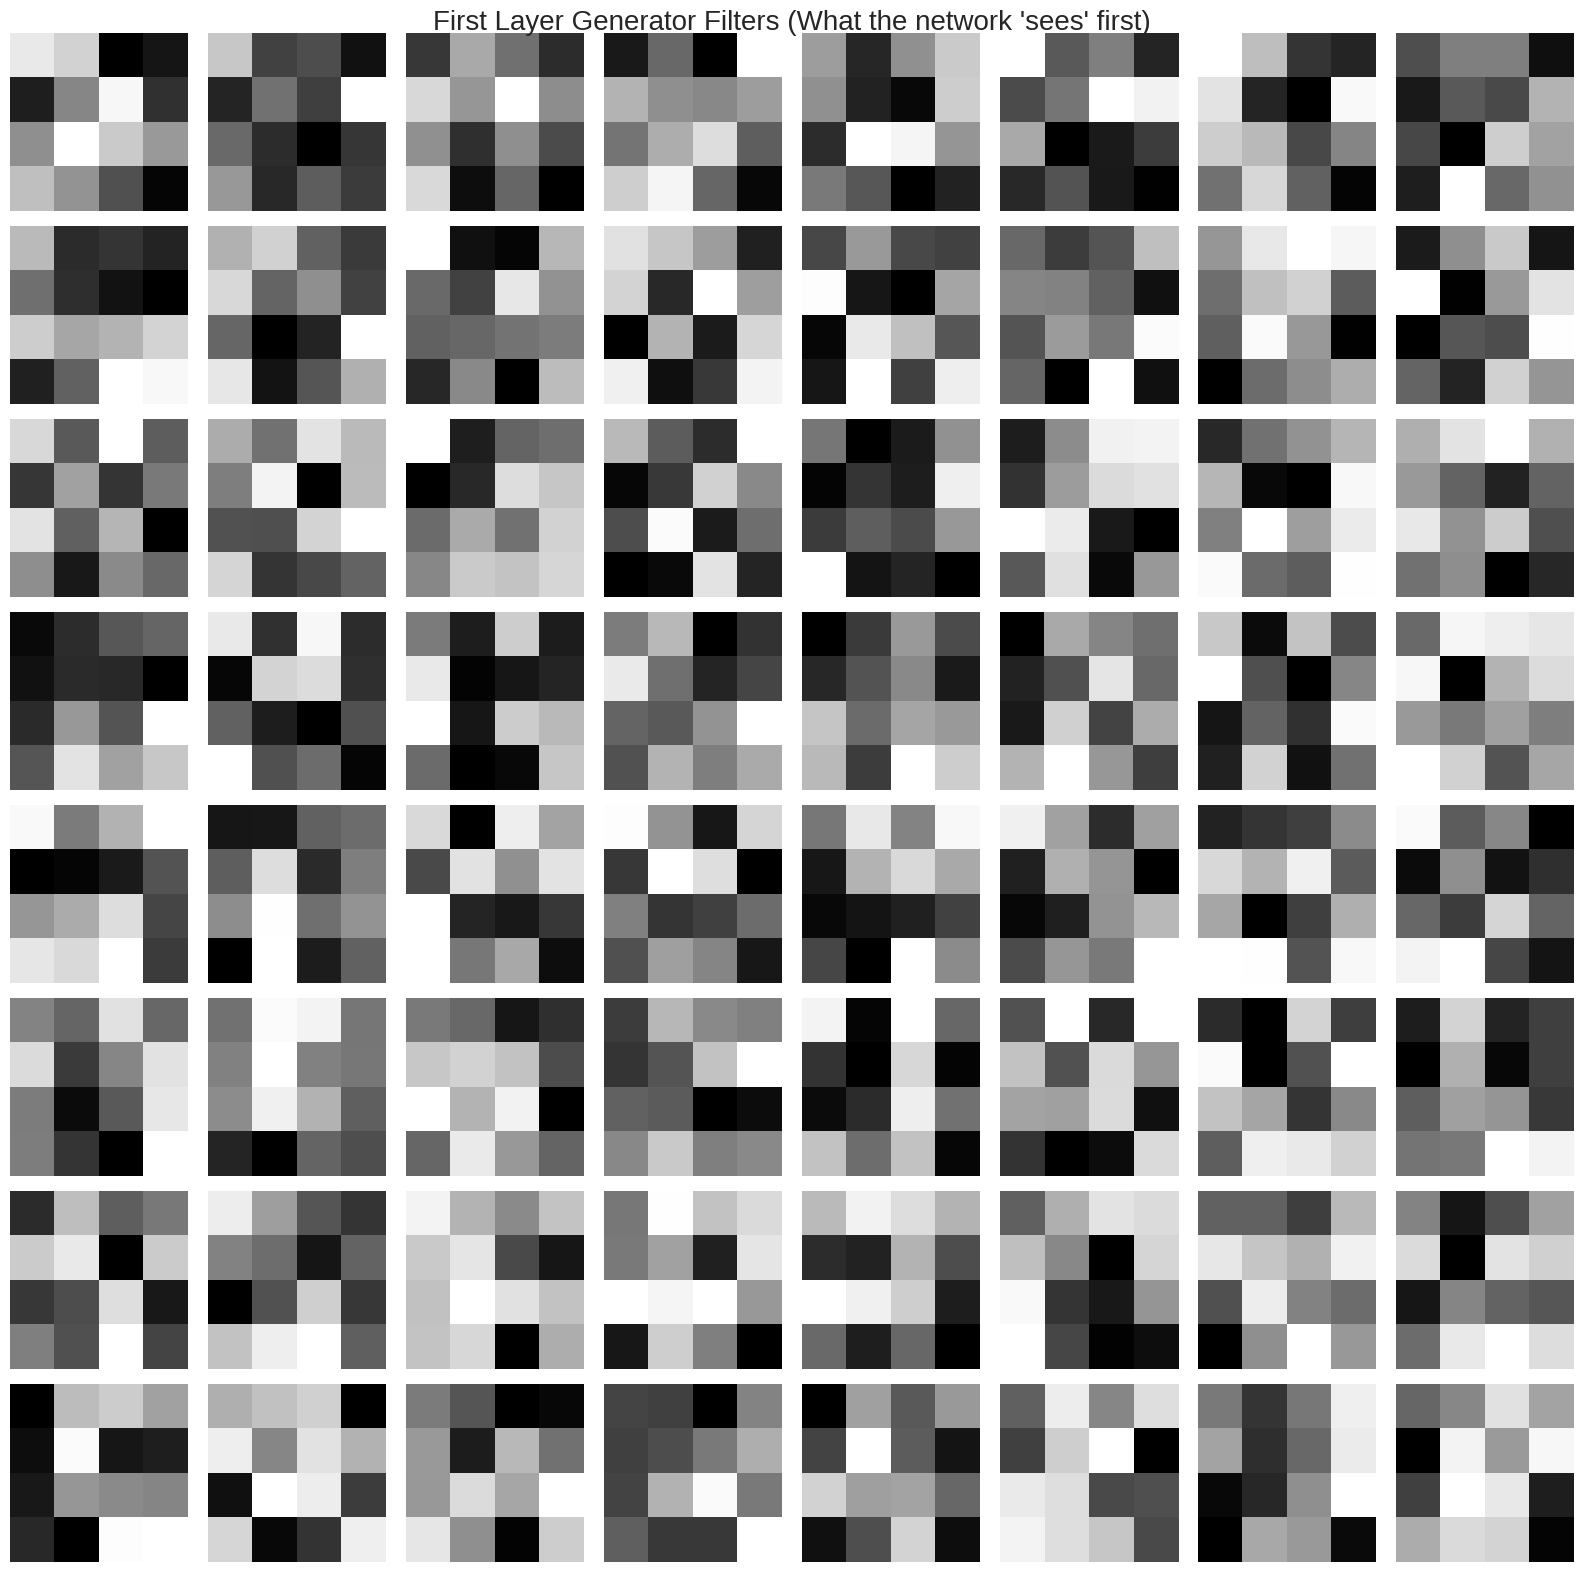

✅ Generator filter visualization saved to 'generator_filters.png'

--- Visualization Complete ---


In [5]:
# network_visualizer.py

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot

# IMPORTANT: You must have the original model class definitions available here.
# Copy the UNetBlock, Generator, and Discriminator classes from your notebook into this file.
# --- Start of Model Class Definitions ---

class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_c),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv(x); return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=2, features=64):
        super().__init__()
        self.initial_down=nn.Sequential(nn.Conv2d(in_channels,features,4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        self.down1=UNetBlock(features,features*2,down=True,act="leaky")
        self.down2=UNetBlock(features*2,features*4,down=True,act="leaky")
        self.down3=UNetBlock(features*4,features*8,down=True,act="leaky")
        self.down4=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down5=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down6=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck=nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1),nn.ReLU())
        self.up1=UNetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up3=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up4=UNetBlock(features*16,features*4,down=False,act="relu")
        self.up5=UNetBlock(features*12,features*2,down=False,act="relu")
        self.up6=UNetBlock(features*6,features,down=False,act="relu")
        self.up7=UNetBlock(features*3,features,down=False,act="relu")
        self.final_up=nn.Sequential(nn.ConvTranspose2d(features*2,1,4,2,1),nn.Tanh())
    def forward(self,x):
        d1=self.initial_down(x);d2=self.down1(d1);d3=self.down2(d2);d4=self.down3(d3);d5=self.down4(d4)
        d6=self.down5(d5);d7=self.down6(d6);bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck);up2=self.up2(torch.cat([up1,d7],1));up3=self.up3(torch.cat([up2,d6],1))
        up4=self.up4(torch.cat([up3,d5],1));up5=self.up5(torch.cat([up4,d4],1));up6=self.up6(torch.cat([up5,d3],1))
        up7=self.up7(torch.cat([up6,d2],1));return self.final_up(torch.cat([up7,d1],1))

class Discriminator(nn.Module):
    def __init__(self, in_channels_x=2, in_channels_y=1, features=[64, 128, 256, 512]):
        super().__init__()
        total_in_channels = in_channels_x + in_channels_y
        self.initial=nn.Sequential(nn.Conv2d(total_in_channels,features[0],4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        layers=[];in_channels=features[0]
        for feature in features[1:]:
            layers.append(nn.Sequential(nn.Conv2d(in_channels,feature,4,1 if feature==features[-1] else 2,1,bias=False,padding_mode="reflect"),nn.InstanceNorm2d(feature),nn.LeakyReLU(0.2)))
            in_channels=feature
        layers.append(nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"))
        self.model=nn.Sequential(*layers)
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1);x=self.initial(x);return self.model(x)

# --- End of Model Class Definitions ---


def visualize_architecture(model, input_tensors, filename, graph_attr={'rankdir': 'LR'}):
    """
    Generates a diagram of the model architecture using torchviz.
    'LR' for left-to-right, 'TB' for top-to-bottom.

    To install dependencies:
    pip install torchviz graphviz
    You may also need to install the Graphviz system package:
    sudo apt-get install graphviz (on Debian/Ubuntu)
    brew install graphviz (on macOS)
    """
    try:
        output = model(*input_tensors) if isinstance(input_tensors, list) else model(input_tensors)
        dot = make_dot(output, params=dict(model.named_parameters()))
        dot.graph_attr.update(graph_attr)
        dot.render(filename, format='png', cleanup=True)
        print(f"✅ Architecture diagram saved to '{filename}.png'")
    except Exception as e:
        print(f"❌ Could not generate architecture diagram. Make sure torchviz and graphviz are installed. Error: {e}")


def visualize_generator_filters(generator_model):
    """
    Visualizes the convolutional filters from the first layer of the generator.
    This shows what basic features the model has learned to detect.
    """
    # Access the weights of the first convolutional layer
    first_layer_weights = generator_model.initial_down[0].weight.data.cpu()

    # We have 2 input channels, let's visualize filters for the first channel (solid rock)
    filters = first_layer_weights[:, 0, :, :].unsqueeze(1) # Select filters for the first input channel

    num_filters = filters.shape[0]
    num_cols = 8
    num_rows = num_filters // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_filters):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')

    plt.suptitle("First Layer Generator Filters (What the network 'sees' first)", fontsize=20)
    plt.tight_layout()
    plt.savefig("generator_filters.png")
    plt.show()
    print("✅ Generator filter visualization saved to 'generator_filters.png'")


if __name__ == '__main__':
    # --- Configuration ---
    DEVICE = "cpu"
    IMG_SIZE = 256
    MODEL_CHECKPOINT_PATH = "checkpoints/gan_checkpoint_epoch_30.pth" # CHANGE THIS to your model

    print("--- Starting Network Visualization ---")

    # 1. Instantiate Models
    gen = Generator(in_channels=2).to(DEVICE)
    disc = Discriminator(in_channels_x=2, in_channels_y=1).to(DEVICE)

    # 2. Load trained weights (optional, but recommended for filter visualization)
    if os.path.exists(MODEL_CHECKPOINT_PATH):
        print(f"Loading checkpoint from {MODEL_CHECKPOINT_PATH}...")
        checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=DEVICE)
        gen.load_state_dict(checkpoint['gen_state_dict'])
        print("Model weights loaded successfully.")
    else:
        print(f"Warning: Checkpoint not found at {MODEL_CHECKPOINT_PATH}. Using randomly initialized weights.")

    # 3. Generate Architecture Diagrams
    print("\nGenerating model architecture diagrams...")
    # Create dummy input tensors with the correct shape: (Batch, Channels, Height, Width)
    dummy_gen_input = torch.randn(1, 2, IMG_SIZE, IMG_SIZE).to(DEVICE)
    dummy_disc_condition = torch.randn(1, 2, IMG_SIZE, IMG_SIZE).to(DEVICE)
    dummy_disc_image = torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE)

    visualize_architecture(gen, dummy_gen_input, "generator_architecture")
    visualize_architecture(disc, [dummy_disc_condition, dummy_disc_image], "discriminator_architecture", graph_attr={'rankdir': 'TB'})

    # 4. Visualize First Layer Filters of the Generator
    print("\nVisualizing generator's first layer convolutional filters...")
    visualize_generator_filters(gen)

    print("\n--- Visualization Complete ---")